In [1]:
import os
import copy
import collections
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import statsmodels.stats.multitest as multi
from scipy.stats import pearsonr
import joblib
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [2]:
input_path = "/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/circExcer/models/saved_models/circRNA_ML_Model_Output"
RNA_Light_path = os.path.join(input_path,"LightGBM")
output_path = "/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/circExcer/SHAP/circRNA_shap_output"
if not (os.path.exists(output_path)):
    os.mkdir(output_path)

# load kmer file
df_kmer_345 = pd.read_csv(os.path.join(input_path,"df_kmer345_freq.tsv"),sep='\t',index_col= 0)
transcript_id = df_kmer_345['RNA_Symbol']
# convert to x:kmer-freq , y:label
del df_kmer_345['RNA_Symbol']
x_kmer = df_kmer_345.values
y_kmer = np.array(df_kmer_345.index)

# load model
RNA_Light = joblib.load(os.path.join(RNA_Light_path,"best_LightGBM_model.pkl"))

In [3]:
df_kmer_345.columns

Index(['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC',
       ...
       'TTTCG', 'TTTCT', 'TTTGA', 'TTTGC', 'TTTGG', 'TTTGT', 'TTTTA', 'TTTTC',
       'TTTTG', 'TTTTT'],
      dtype='object', length=1344)

In [4]:
shap.initjs() 
# Interpret the model's predictions on the entire dataset for nuclear/cytosol localization 
RNA_Light_explainer = shap.TreeExplainer(RNA_Light)
# shap_values_RNA_Light = RNA_Light_explainer.shap_values(df_kmer_345)[1]
shap_values_RNA_Light = RNA_Light_explainer.shap_values(df_kmer_345)

# Convert np.array to dataframe with column names
shap_df = pd.DataFrame(shap_values_RNA_Light,columns = df_kmer_345.columns)
shap_df.index = transcript_id 
shap_df.to_csv(os.path.join(output_path,"RNA-Light_lncRNA_shap_df.txt"),sep='\t')

# Mean(abs(shap_value))
mean_abs_shap_val = shap_df.apply(lambda x:abs(x).mean(),axis=0)



/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [5]:

# Calculate pearson correlation
lnc_num = shap_df.shape[0]
total_df = pd.concat([df_kmer_345,shap_df])
# Pearson correlation coefficient (r and p_value)
total_df = total_df.replace([np.inf, -np.inf], np.nan)
total_df = total_df.fillna(total_df.mean())
pearsonr_r = total_df.apply(lambda x:pearsonr(x[:lnc_num],x[lnc_num:2*lnc_num])[0],axis=0)
pearsonr_p = total_df.apply(lambda x:pearsonr(x[:lnc_num],x[lnc_num:2*lnc_num])[1],axis=0)
fdr =pd.Series(multi.multipletests(pearsonr_p)[1],index = pearsonr_p.index)

# Merge to kmer_info ["mean_abs_shap","pearsonr_r","pearsonr_p","fdr"]
kmer_info_df = pd.concat([mean_abs_shap_val,pearsonr_r,pearsonr_p,fdr],axis=1) 
kmer_info_df.columns = ["mean_abs_shap","pearsonr_r","pearsonr_p","fdr"]

kmer_info_df.to_csv(os.path.join(output_path,"kmer_importance_quantification_info.txt"),sep='\t')

/tmp/ipykernel_4446/2453911986.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_r = total_df.apply(lambda x:pearsonr(x[:lnc_num],x[lnc_num:2*lnc_num])[0],axis=0)
/tmp/ipykernel_4446/2453911986.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_p = total_df.apply(lambda x:pearsonr(x[:lnc_num],x[lnc_num:2*lnc_num])[1],axis=0)


In [6]:
abs_shape_3mer = mean_abs_shap_val[0:64]
abs_shape_4mer = mean_abs_shap_val[64:64+256]
abs_shape_5mer = mean_abs_shap_val[64+256:64+256+1024]

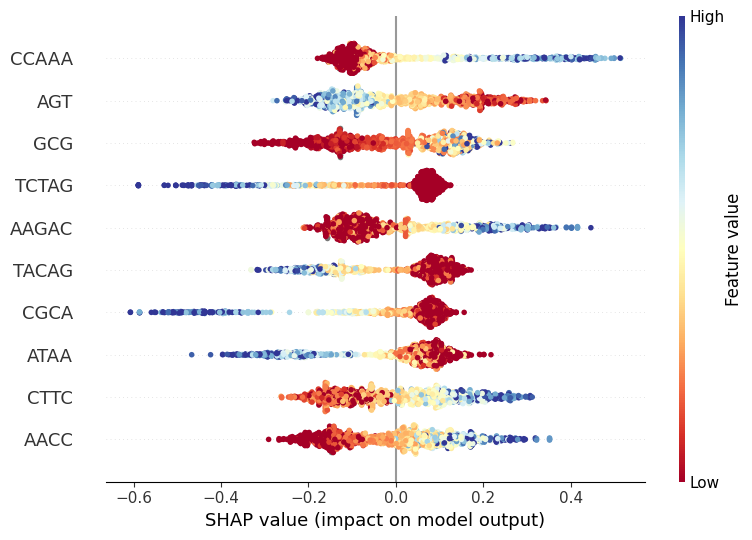

In [35]:
# Define colormap
my_colormap= plt.get_cmap("RdYlBu")

# Plot the summary without showing it
plt.figure()
shap.summary_plot(shap_values_RNA_Light,features =df_kmer_345,max_display = 10,show=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_colormap)
plt.savefig(os.path.join(output_path,"SHAP_total_top10_kmer.pdf"), format='pdf', dpi=1200)

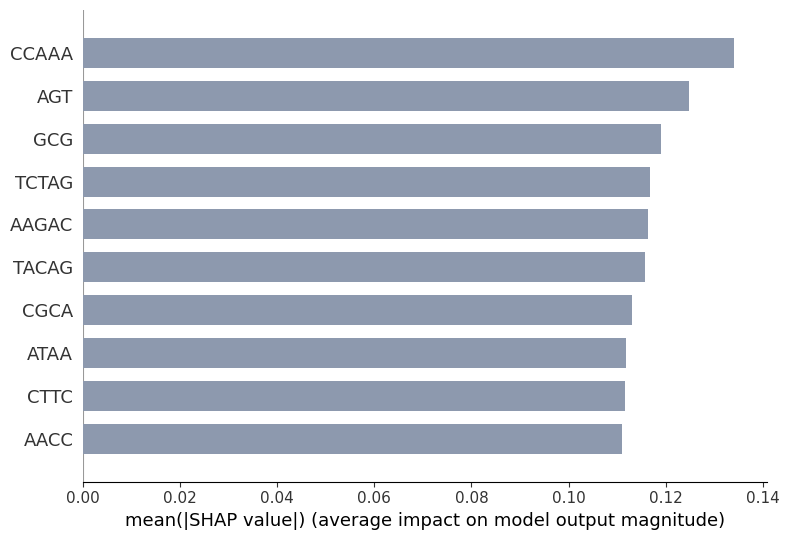

In [8]:
shap.summary_plot(shap_values_RNA_Light,df_kmer_345,plot_type = "bar",max_display = 10,color = "#8d99ae",show = False)
plt.savefig(os.path.join(output_path,"SHAP_total_top10_kmer_bar.pdf"), format='pdf', dpi=1200)

/tmp/ipykernel_4446/3158940952.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='mean_abs_shap', y='kmer_length', data=df, orient='h', palette=chosen_color)


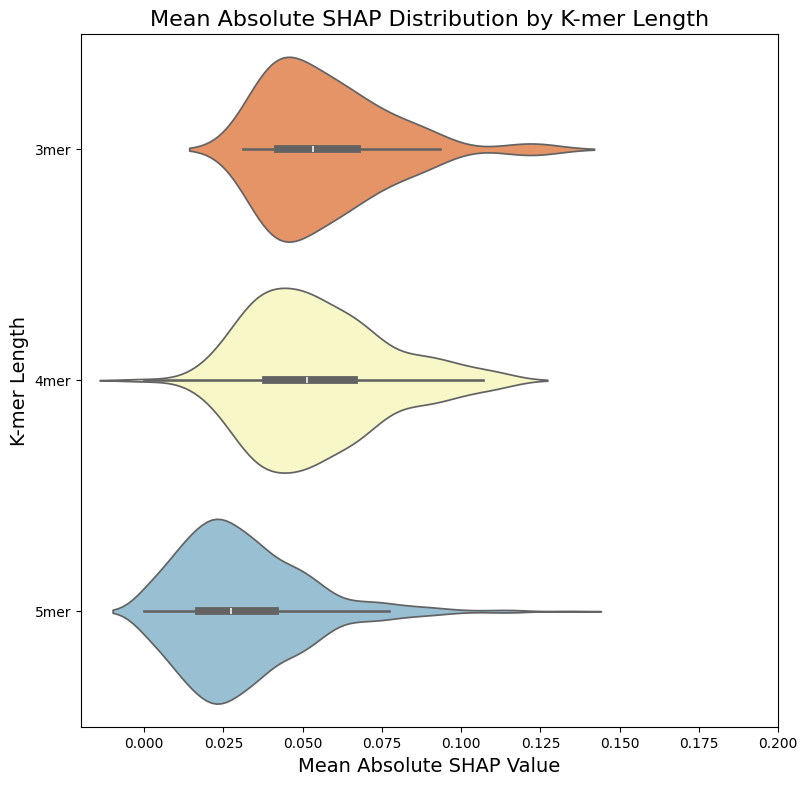

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from matplotlib.ticker import MaxNLocator

# 假设 mean_abs_shap_val 是一个 Series，索引为k-mer的字符串，值为其对应的平均SHAP绝对值。
# 比如 mean_abs_shap_val = pd.Series(...)

# 按k-mer长度（3mer, 4mer, 5mer）分组
data_3mer = mean_abs_shap_val[mean_abs_shap_val.index.str.len() == 3]
data_4mer = mean_abs_shap_val[mean_abs_shap_val.index.str.len() == 4]
data_5mer = mean_abs_shap_val[mean_abs_shap_val.index.str.len() == 5]

# 创建一个包含k-mer长度和对应mean_abs_shap的DataFrame
df = pd.DataFrame({
    'mean_abs_shap': pd.concat([data_3mer, data_4mer, data_5mer]),
    'kmer_length': ['3mer'] * len(data_3mer) + ['4mer'] * len(data_4mer) + ['5mer'] * len(data_5mer)
})

# 配色方案接口
color_schemes = [
    "coolwarm",       # 热冷配色
    "Spectral",       # 光谱配色
    "Set2",           # 适合分类数据
    "RdBu_r",         # 红蓝配色（反转）
    "viridis",        # Viridis色阶（渐变色）
    "plasma",         # Plasma色阶（渐变色）
    "cividis",        # Cividis色阶（渐变色，适合色盲人群）
    "Blues",          # 蓝色渐变
    "RdYlBu",         # 红黄蓝色系
    "BrBG",           # Brown-Blue-Green
]

# 选择配色方案，可以通过在列表中挑选（如"Set2"）
chosen_color = "RdYlBu"

# 绘制横向小提琴图
plt.figure(figsize=(9, 9))
sns.violinplot(x='mean_abs_shap', y='kmer_length', data=df, orient='h', palette=chosen_color)

# 设置标题和轴标签
plt.title('Mean Absolute SHAP Distribution by K-mer Length', fontsize=16)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.ylabel('K-mer Length', fontsize=14)
plt.xlim(-0.02,0.2)
# # 显著性检验：Kruskal-Wallis检验
# stat_34, p_value_34 = kruskal(data_3mer, data_4mer)
# stat_45, p_value_45 = kruskal(data_4mer, data_5mer)
# stat_35, p_value_35 = kruskal(data_3mer, data_5mer)

# # 添加显著性标注（基于p值）
# def add_significance(ax, p_value, group1, group2):
#     if p_value < 0.05:
#         ax.text(0.5, 0.95, f"p = {p_value:.3f}", ha='center', va='center', 
#                 transform=ax.transAxes, fontsize=12, color='red', fontweight='bold')

# # 在图上标注显著性检验的结果
# ax = plt.gca()
# add_significance(ax, p_value_34, '3mer', '4mer')
# add_significance(ax, p_value_45, '4mer', '5mer')
# add_significance(ax, p_value_35, '3mer', '5mer')

# 保存图像
plt.savefig('mean_abs_shap_violin_plot.pdf', format='pdf', dpi=1200)

plt.show()


In [13]:
stat_34, p_value_34 = kruskal(data_3mer, data_4mer)
stat_45, p_value_45 = kruskal(data_4mer, data_5mer)
stat_35, p_value_35 = kruskal(data_3mer, data_5mer)

In [14]:
print(p_value_34,p_value_45, p_value_35)

0.2767812042697733 1.2373050417368655e-52 2.9755835722497285e-21


In [21]:
min(data_5mer)

0.0